# percent-allocate

Maintain a percent allocation of a security in account

In [1]:
# use future imports for python 3.x forward compatibility
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

In [3]:
pf.DEBUG = False

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Define target_percent and band

In [5]:
target_percent = 50
band = 3

sma200_band = 3.5/100

Define Strategy Class 

In [6]:
class Strategy(object):

    def __init__(self, symbol, capital, start, end):
        self._symbol = symbol
        self._capital = capital
        self._start = start
        self._end = end

    def _algo(self):
        self._tlog.cash = self._capital

        for i, row in enumerate(self._ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high
            low = row.low
            close = row.close
            sma200 = row.sma200
            end_flag = True if (i == len(self._ts) - 1) else False
            shares = 0

            # adjust shares
            if ((self._tlog.percent(close) > target_percent+band or
                self._tlog.percent(close) < target_percent-band)
                and close > sma200*(1+sma200_band)
                and not end_flag):
                # adjust shares to target_percent
                shares = self._tlog.adjust_percent(date, close, target_percent)   
            # close out
            elif (close < sma200*(1-sma200_band)
                  or end_flag):
                # adjust shares to 0
                shares = self._tlog.adjust_percent(date, close, 0)

            if shares > 0:
                pf.DBG("{0} BUY  {1} {2} @ {3:.2f}".format(
                       date, shares, self._symbol, close))
            elif shares < 0:
                pf.DBG("{0} SELL {1} {2} @ {3:.2f}".format(
                       date, -shares, self._symbol, close))

            # record daily balance
            self._dbal.append(date, high, low, close,
                              self._tlog.shares, self._tlog.cash)

    def run(self):
        self._ts = pf.fetch_timeseries(self._symbol)
        self._ts = pf.select_tradeperiod(self._ts, self._start, self._end,
                                         use_adj=True, pad=False)

        # Add technical indicator: 200 day sma
        sma200 = SMA(self._ts, timeperiod=200)
        self._ts['sma200'] = sma200
        
        self._ts, self._start = pf.finalize_timeseries(self._ts, self._start)

        self._tlog = pf.TradeLog()
        self._dbal = pf.DailyBal()

        self._algo()

    def get_logs(self):
        """ return DataFrames """
        self.rlog = self._tlog.get_log_raw()
        self.tlog = self._tlog.get_log()
        self.dbal = self._dbal.get_log(self.tlog)
        return self.rlog, self.tlog, self.dbal

    def get_stats(self):
        stats = pf.stats(self._ts, self.tlog, self.dbal, self._capital)
        return stats

Run Strategy

In [7]:
s = Strategy(symbol, capital, start, end)
s.run()

Retrieve log DataFrames

In [8]:
rlog, tlog, dbal = s.get_logs()
stats = s.get_stats()

In [9]:
rlog.tail(10)

,date,price,shares,entry_exit,symbol
32,2013-12-26,163.42,6,exit,
33,2014-12-03,187.35,5,exit,
34,2015-08-21,180.95,80,exit,
35,2016-04-01,192.37,76,entry,
36,2017-02-15,221.94,5,exit,
37,2017-12-08,254.42,5,exit,
38,2018-10-29,257.45,66,exit,
39,2019-03-18,278.30,61,entry,
40,2019-12-20,320.73,4,exit,
41,2020-02-14,337.60,57,exit,


In [10]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,symbol
22,2012-01-10,110.06,2012-09-13,126.14,16.08,96.48,6,12944.17,
23,2012-01-10,110.06,2013-05-08,142.94,32.88,197.27,6,13141.44,
24,2012-01-10,110.06,2013-12-26,163.42,53.36,320.15,6,13461.59,
25,2012-01-10,110.06,2014-12-03,187.35,77.29,386.46,5,13848.05,
26,2012-01-10,110.06,2015-08-21,180.95,70.89,5670.94,80,19518.99,
27,2016-04-01,192.37,2017-02-15,221.94,29.58,147.88,5,19666.87,
28,2016-04-01,192.37,2017-12-08,254.42,62.05,310.26,5,19977.13,
29,2016-04-01,192.37,2018-10-29,257.45,65.09,4295.74,66,24272.87,
30,2019-03-18,278.30,2019-12-20,320.73,42.43,169.71,4,24442.58,
31,2019-03-18,278.30,2020-02-14,337.60,59.30,3379.89,57,27822.47,


In [11]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2020-02-10,37660.02,37457.10,37656.03,57,18579.27,-
2020-02-11,37789.41,37656.03,37689.09,57,18579.27,-
2020-02-12,37825.32,37755.78,37812.21,57,18579.27,-
2020-02-13,37852.11,37706.19,37791.69,57,18579.27,-
2020-02-14,37822.47,37822.47,37822.47,0,37822.47,X


Generate strategy stats - display all available stats

In [12]:
pf.print_full(stats)

start                                                  1993-11-11
end                                                    2020-02-14
beginning_balance                                           10000
ending_balance                                           37822.47
total_net_profit                                         27822.47
gross_profit                                             28027.71
gross_loss                                                -205.24
profit_factor                                              136.56
return_on_initial_capital                                  278.22
annual_return_rate                                           5.20
trading_period                           26 years 3 months 3 days
pct_time_in_market                                          75.71
total_num_trades                                               32
trades_per_year                                              1.22
num_winning_trades                                             31
num_losing

Run Benchmark

In [13]:
benchmark = pf.Benchmark(symbol, capital, s._start, s._end)
benchmark.run()

1993-11-11 00:00:00 BUY  215 SPY @ 46.38
2020-02-14 00:00:00 SELL 215 SPY @ 337.60


Retrieve benchmark logs

In [14]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [15]:
benchmark.stats = benchmark.get_stats()
pf.print_full(benchmark.stats)

start                                                  1993-11-11
end                                                    2020-02-14
beginning_balance                                           10000
ending_balance                                           72613.38
total_net_profit                                         62613.38
gross_profit                                             62613.38
gross_loss                                                   0.00
profit_factor                                                1000
return_on_initial_capital                                  626.13
annual_return_rate                                           7.84
trading_period                           26 years 3 months 3 days
pct_time_in_market                                         100.00
total_num_trades                                                1
trades_per_year                                              0.04
num_winning_trades                                              1
num_losing

Plot Equity Curves: Strategy vs Benchmark

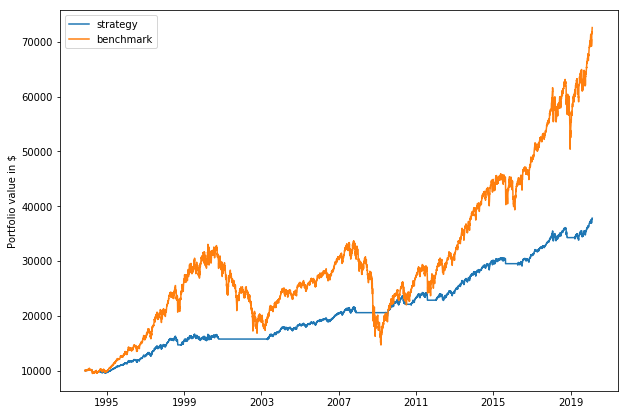

In [16]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

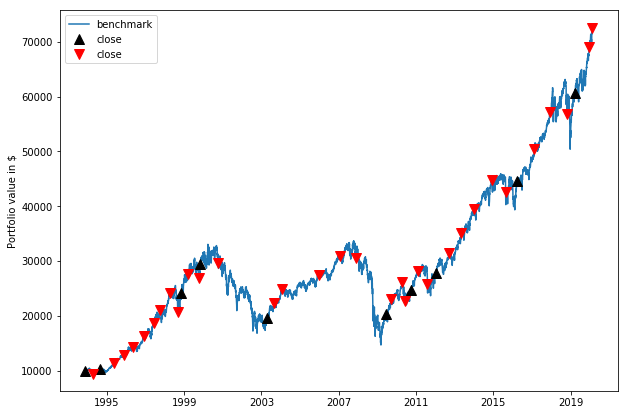

In [17]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,5.20,7.84
max_closed_out_drawdown,-10.06,-56.42
drawdown_annualized_return,-1.94,-7.19
drawdown_recovery,-0.30,-1.42
best_month,7.62,22.70
worst_month,-6.82,-29.78
sharpe_ratio,0.86,0.50
sortino_ratio,0.97,0.65
monthly_std,1.53,4.31


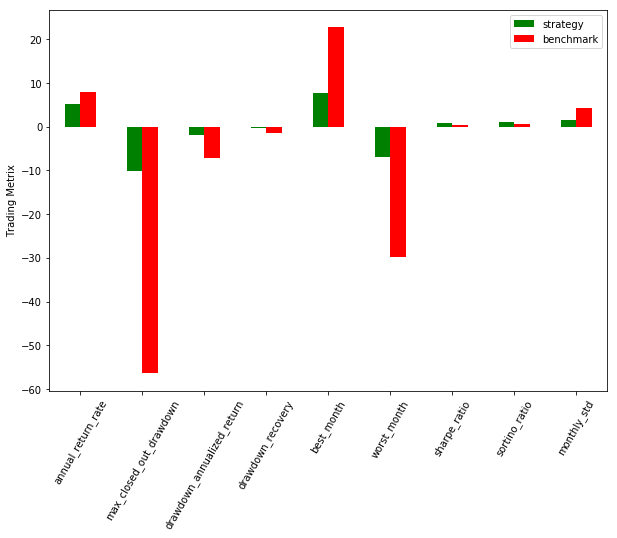

In [18]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')
df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df